In [17]:
import numpy as np # linear algebra
import os
import matplotlib.pyplot as plot
from PIL import Image
import cv2
from sklearn.cluster import KMeans
import random


The images are side-by-side images of the raw image and a color coded segmented image. The function splits the image into seperate images

In [18]:
# loading images from the training set of city scape data 
def LoadImage(name, path="cityscapes_data\\cityscapes_data\\train",
             rotation=0.0, flip=False, cut_bottom=58,
             size=(256, 200)):
    img = Image.open(path+"/"+name)
    img = np.array(img)
    # second part of the appended image is the already segmented image 
    seg = img[:-cut_bottom, 256:]
    # 1st part is the original image without segmentation
    img = img[:-cut_bottom, 0:256]
    
    #Brighter image will have all pixels confined to high values.
    #But a good image will have pixels from all regions of the image. 
    # So we need to stretch this histogram to either ends and that is what Histogram Equalization does (in simple words).
    # This normally improves the contrast of the image.
    #for that we will be using the cv2.equalizeHist for this  purpose
    for i in range(3):
        zimg = img[:,:,i]
        zimg = cv2.equalizeHist(zimg)
        img[:,:,i] = zimg
    
    #take the matrix as the input and returns the image object CASA format return
    img = Image.fromarray(img).resize(size)
    seg = Image.fromarray(seg).resize(size)
    
    
   #simpe data augmentation options such as flipping and rotating
    img = img.rotate(rotation)
    seg = seg.rotate(rotation)

    img = np.array(img)
    seg = np.array(seg)

    if flip:
        img = img[:,::-1,:]
        seg = seg[:,::-1,:]

    # Returning the image in normalized form 
    return img/255, seg/255

In [19]:
#loading image formm the training set by giving path 
mypath = "cityscapes_data\\cityscapes_data\\train"
files = os.listdir(mypath)[0:10]

As there are more than only a few discrete colors in the segmented image. To find the most imortant colors and identify similar colors we can use KMeans clustering. This also allows us to go from a color representation to a class representation.

In [16]:
colors = []
for file in files:
    img, seg = LoadImage(file)
    colors.append(seg.reshape(seg.shape[0]*seg.shape[1], 3))
colors = np.array(colors)
colors = colors.reshape((colors.shape[0]*colors.shape[1],3))

print("segmented image shape", seg.shape[0])
print("Original image shape", seg.shape[1])

#applying To find the most imortant colors and identify similar colors we will be using KMeans clustering
km = KMeans(13)
km.fit(colors)


segmented image shape 200
Original image shape 256


KMeans(n_clusters=13)

After clustering the image contains information about 13 different layers. Computer displays can only utilize the RGB colorspace. This function converts the layer representation to a color representation. This is just for visualizing.

In [20]:
def LayersToRGBImage(img):
    colors = [(255,0,0), (0,255,0), (0,0,255),
             (255,255,0), (255,0,255), (0,255,255),
             (255,255,255), (200,50,0),(50,200,0),
             (50,0,200), (200,200,50), (0,50,200),
             (0,200,50), (0,0,0)]
    
    nimg = np.zeros((img.shape[0], img.shape[1], 3))
    for i in range(img.shape[2]):
        c = img[:,:,i]
        col = colors[i]
        
        for j in range(3):
            nimg[:,:,j]+=col[j]*c
    nimg = nimg/255.0
    return nimg

Text(0.5, 1.0, 'semantic segmented image ')

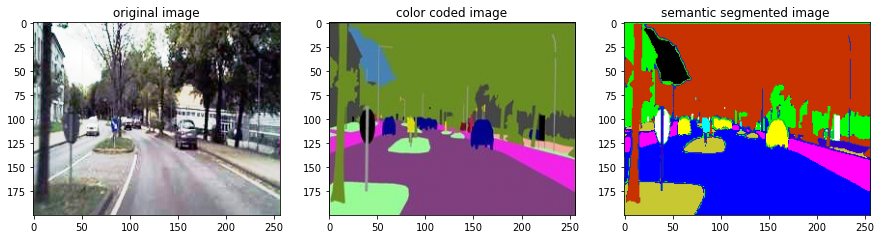

In [23]:
#This function converts the discrete color representation (output of the color clustering) to a 13-dimensional class representation
def ColorsToClass(seg):
    s = seg.reshape((seg.shape[0]*seg.shape[1],3))
    s = km.predict(s)
    s = s.reshape((seg.shape[0], seg.shape[1]))
    
    n = len(km.cluster_centers_)
    
    cls = np.zeros((seg.shape[0], seg.shape[1], n))
    
    for i in range(n):
        m = np.copy(s)
        m[m!=i] = 0
        m[m!=0] = 1
        
        cls[:,:,i]=m
        
    return cls

img, seg = LoadImage("151.jpg")
seg2 = ColorsToClass(seg)
seg2 = LayersToRGBImage(seg2)
total = cv2.addWeighted(img, 0.6, seg2, 0.4, 0)
fig, axes = plot.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img)
axes[0].set_title("original image")
axes[1].imshow(seg)
axes[1].set_title("color coded image")
axes[2].imshow(seg2)
axes[2].set_title("semantic segmented image ")

Text(0.5, 1.0, 'semantic segmented image ')

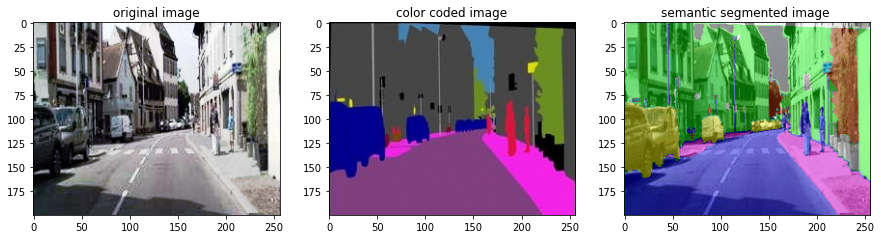

In [22]:
img, seg = LoadImage("2251.jpg")
seg2 = ColorsToClass(seg)
seg2 = LayersToRGBImage(seg2)
total = cv2.addWeighted(img, 0.6, seg2, 0.4, 0)
fig, axes = plot.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img)
axes[0].set_title("original image")
axes[1].imshow(seg)
axes[1].set_title("color coded image")
axes[2].imshow(total)
axes[2].set_title("semantic segmented image ")